In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
!pip show bayesian-optimization

In [8]:
!pip install bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable


In [9]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [10]:
!pip install boruta

Defaulting to user installation because normal site-packages is not writeable
  Using cached Boruta-0.3-py3-none-any.whl (56 kB)


In [11]:
from explainer_tabular import LimeTabularExplainer, Sklearn_Lime

In [12]:
from load_hugaDBdataset2 import LoadDataset

In [13]:
test = LoadDataset()
X = test.data.data
Y = test.data.target

In [14]:
X

array([[-7868, -1336, 13400, ...,    -3,     9,   120],
       [-7956, -1384, 13468, ...,    -3,     7,   120],
       [-7892, -1348, 13492, ...,    -7,     9,   120],
       ...,
       [-7944, -1248, 13292, ...,    -6,    -8,   120],
       [-7920, -1332, 13392, ...,    -5,    -3,   120],
       [-7868, -1288, 13384, ...,    -5,     7,   120]], dtype=int64)

In [15]:
Y

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
feature_names = test.data.feature_names
feature_names

['accelerometer_right_foot_x',
 'accelerometer_right_foot_y',
 'accelerometer_right_foot_z',
 'gyroscope_right_foot_x',
 'gyroscope_right_foot_y',
 'gyroscope_right_foot_z',
 'accelerometer_right_shin_x',
 'accelerometer_right_shin_y',
 'accelerometer_right_shin_z',
 'gyroscope_right_shin_x',
 'gyroscope_right_shin_y',
 'gyroscope_right_shin_z',
 'accelerometer_right_thigh_x',
 'accelerometer_right_thigh_y',
 'accelerometer_right_thigh_z',
 'gyroscope_right_thigh_x',
 'gyroscope_right_thigh_y',
 'gyroscope_right_thigh_z',
 'accelerometer_left_foot_x',
 'accelerometer_left_foot_y',
 'accelerometer_left_foot_z',
 'gyroscope_left_foot_x',
 'gyroscope_left_foot_y',
 'gyroscope_left_foot_z',
 'accelerometer_left_shin_x',
 'accelerometer_left_shin_y',
 'accelerometer_left_shin_z',
 'gyroscope_left_shin_x',
 'gyroscope_left_shin_y',
 'gyroscope_left_shin_z',
 'accelerometer_left_thigh_x',
 'accelerometer_left_thigh_y',
 'accelerometer_left_thigh_z',
 'gyroscope_left_thigh_x',
 'gyroscope_left

In [17]:
target_names = test.data.target_names
target_names

array(['sitting', 'standing'], dtype='<U8')

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [19]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=0,
              solver='lbfgs')

In [20]:
y_pred = nn.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
accuracy = accuracy_score(y_test, y_pred.round())
accuracy

0.5116731517509727

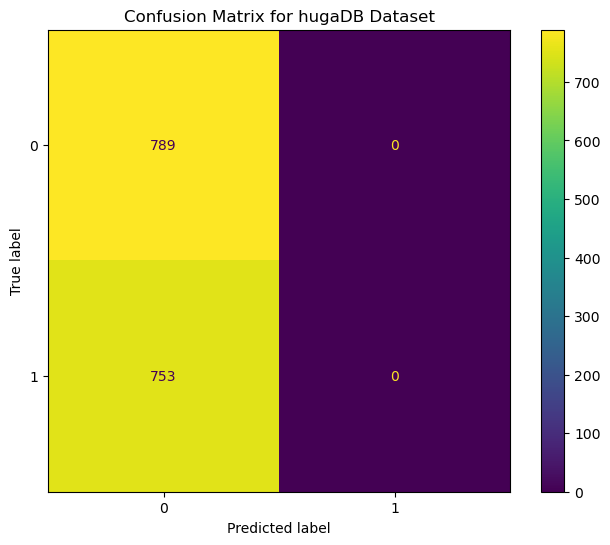

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix for hugaDB Dataset")
plt.show()

In [23]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.51      1.00      0.68       789\n           1       0.00      0.00      0.00       753\n\n    accuracy                           0.51      1542\n   macro avg       0.26      0.50      0.34      1542\nweighted avg       0.26      0.51      0.35      1542\n'

In [24]:
i = np.random.randint(0, x_test.shape[0])

In [25]:
#GMM clustering
model = GaussianMixture(n_components=4).fit(X)
labels = model.predict(X)
names = list(feature_names)+["membership"]
clustered_data = np.column_stack([X,labels])
clustered_data

array([[-7868, -1336, 13400, ...,     9,   120,     1],
       [-7956, -1384, 13468, ...,     7,   120,     1],
       [-7892, -1348, 13492, ...,     9,   120,     1],
       ...,
       [-7944, -1248, 13292, ...,    -8,   120,     1],
       [-7920, -1332, 13392, ...,    -3,   120,     1],
       [-7868, -1288, 13384, ...,     7,   120,     1]], dtype=int64)

In [26]:
#KNN classification
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x_train)
distances, indices = nbrs.kneighbors(x_test)
clabel = labels

In [27]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [28]:
def jaccard_distance(usecase):
    sim = []
    for l in usecase:
        i_sim = []
        for j in usecase:
            i_sim.append(1 - jaccard_similarity(l, j))
        sim.append(i_sim)
    return sim

In [29]:
x = 4
maxRsquared=0.9
clustered_data2 = np.delete(clustered_data, 37, axis=1)

In [30]:
def OptiLIME_loss(kernel_width):
    single_lime = Sklearn_Lime(mode="classification",
                               verbose=False,
                               discretize_continuous=True,
                               kernel_width=kernel_width,
                               maxRsquared=maxRsquared,
                               epsilon=None,
                               clustered_data =clustered_data2)
                                                           
    single_lime.fit(clustered_data2)
 
    return single_lime.score(clustered_data2[x,:], nn.predict_proba)

In [31]:
pbounds={'kernel_width':[0.1,1.0]}
optimizer=BayesianOptimization(f=OptiLIME_loss, pbounds=pbounds,verbose=2,random_state=4)
optimizer.maximize(init_points=5,n_iter=10)
best_width =optimizer.max["params"]["kernel_width"]

best_width

|   iter    |  target   | kernel... |
-------------------------------------


TypeError: Sklearn_Lime.__init__() got an unexpected keyword argument 'epsilon'

In [ ]:
lime_exp=[]
elime_exp = []

In [ ]:
explainer = LimeTabularExplainer(x_train,
                                 mode="classification",
                                 verbose=False,
                                 discretize_continuous=True,
                                 feature_names=feature_names,
                                 class_names=target_names,
                                 kernel_width=best_width,
                                 )

In [ ]:
for i in range(0, 10):
        p_label = clabel[indices[x]]
        N = clustered_data[clustered_data[:,37] == clabel[p_label]]
        subset = np.delete(N, 37, axis=1)
                  
        exp_elime = explainer.explain_instance_gmmclust(x_test[x],
                                             nn.predict_proba,
                                             num_features=10,
                                             model_regressor=LinearRegression(),
                                             clustered_data = subset,
                                             regressor = 'linear', explainer='elime', labels=(0,1))
        exp_elime.show_in_notebook(show_table=True)
       
        fig_elime, r_features = exp_elime.as_pyplot_to_figure(type='h', name = i+.6, label='0')
        elime_exp.append(r_features)
        

        exp_lime = explainer.explain_instance_gmmclust(x_test[x],
                                             nn.predict_proba,
                                             num_features=10,
                                             model_regressor=LinearRegression(),
                                             regressor = 'linear', explainer='lime', labels=(0,1))
        exp_lime.show_in_notebook(show_table=True)

        fig_elime, r_features = exp_lime.as_pyplot_to_figure(type='h', name = i+.5, label='0')
        lime_exp.append(r_features)

In [ ]:
sim = jaccard_distance(elime_exp)
np.savetxt("results/rf_dlime_jdist_ildp.csv", sim, delimiter=",")
print(np.asarray(sim).mean())
plt.matshow(sim);
plt.colorbar()